# Multisensor rail detection in automatic train operations - Splitting dataset

Attila Kovacs
25.9.2023


## Introduction

In this notebeook, we will split the dataset into train, validation, and test set.
For each dataset, we generate the labels and store the files in the required directory structure.


## Load required packages and dataset

In [1]:

import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob

import pandas as pd
import json
from datetime import datetime

import os
import shutil
from random import randint
import seaborn as sns
import warnings
from utils import generate_train_val_test_split, find_contours, generate_mask, write_dataset_to_directory
%matplotlib inline

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'



In [2]:
max(glob("./dataframe_dumps/df_eda_*"), key=os.path.getmtime)

'./dataframe_dumps\\df_eda_09-28-2023_10-07-41.json'

In [3]:
df = pd.read_json(max(glob("./dataframe_dumps/df_eda_*"), key=os.path.getmtime))

## Perform data split

Given the fact that certain images are very similar as they are extracted from the same video, we perform a random split on different locations.
We aim for a 70/15/15 split. However, as the number of images varies for different folders it is not possible to generate the exact split.

seed: 93
set
train    5506
val       987
test      928
Name: count, dtype: int64


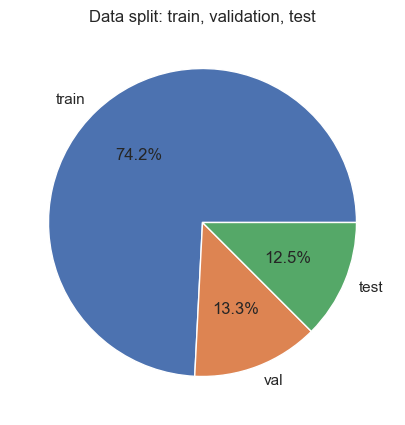

In [53]:
# seed = randint(0, 100)
seed = 93
print(f"seed: {seed}")
df_split = generate_train_val_test_split(
    df=df, seed=seed, val_ratio=0.15, test_ratio=0.15
)
temp = df_split[["path", "set"]].drop_duplicates()["set"].value_counts()
print(temp)

labels = temp.index
values = temp.values
plt.pie(values, labels=labels, autopct="%.1f%%")
_ = plt.title("Data split: train, validation, test")

### Train set

In [15]:
df_split[df_split["set"] == "train"].tag.unique()

array(['10_station_suelldorf_10.1', '11_main_station_11.1',
       '12_vegetation_steady_12.1', '13_station_ohlsdorf_13.1',
       '14_signals_station_14.2', '14_signals_station_14.3',
       '15_construction_vehicle_15.1', '17_signal_bridge_17.1',
       '19_vegetation_curve_19.1', '1_calibration_1.1',
       '20_vegetation_squirrel_20.1', '21_station_wedel_21.2',
       '21_station_wedel_21.3', '2_station_berliner_tor_2.1',
       '3_fire_site_3.1', '3_fire_site_3.2', '3_fire_site_3.4',
       '4_station_pedestrian_bridge_4.1',
       '4_station_pedestrian_bridge_4.3',
       '4_station_pedestrian_bridge_4.4', '5_station_bergedorf_5.1',
       '5_station_bergedorf_5.2', '6_station_klein_flottbek_6.1',
       '6_station_klein_flottbek_6.2',
       '7_approach_underground_station_7.1',
       '7_approach_underground_station_7.3', '8_station_altona_8.1',
       '8_station_altona_8.2', '9_station_ruebenkamp_9.3',
       '9_station_ruebenkamp_9.4', '9_station_ruebenkamp_9.5',
       '9_st

### Validation set

In [16]:
df_split[df_split["set"] == "val"].tag.unique()

array(['16_under_bridge_16.1', '18_vegetation_switch_18.1',
       '1_calibration_1.2', '3_fire_site_3.3', '9_station_ruebenkamp_9.1',
       '9_station_ruebenkamp_9.2'], dtype=object)

### Test set

In [17]:
df_split[df_split["set"] == "test"].tag.unique()

array(['14_signals_station_14.1', '21_station_wedel_21.1',
       '4_station_pedestrian_bridge_4.2',
       '4_station_pedestrian_bridge_4.5',
       '7_approach_underground_station_7.2', '8_station_altona_8.3'],
      dtype=object)

## Approach for generating labels

10_station_suelldorf_10.1/rgb_highres_center/216_1631703820.700000022.png


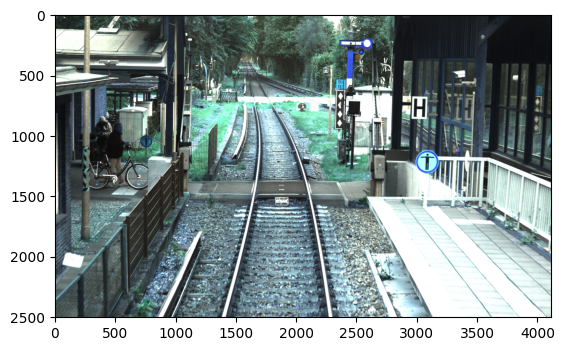

In [19]:
# pick a random image
df_test = df_split[df_split["path"] == df_split["path"].values[10]]
print(df_test["path"].iloc[0])
img = cv2.imread(f"./orig_data/DB/{df_test['path'].iloc[0]}")
_ = plt.imshow(img)

### Generate mask

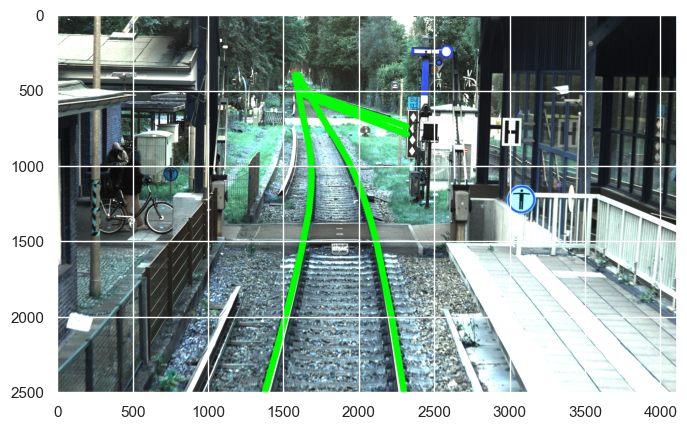

In [43]:
thickness = int(img.shape[1] / 100)
img_temp = img.copy()
for idx, row in df_test.iterrows():
    cv2.polylines(
        img_temp,
        np.int32([row["poly2d"]]),
        isClosed=row["closed"],
        color=(0, 255, 0),
        thickness=thickness,
    )
_ = plt.imshow(img_temp)

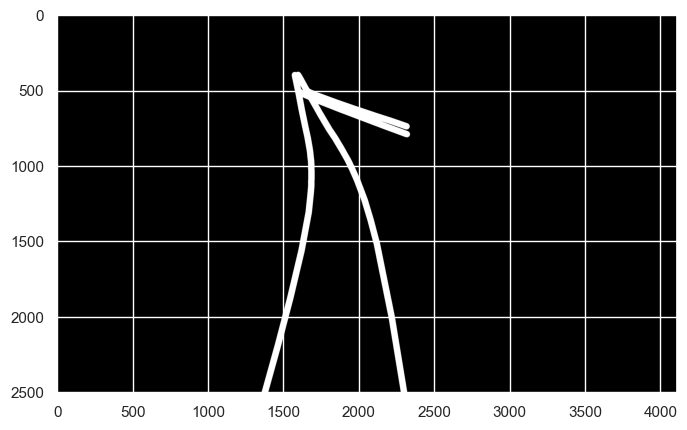

In [44]:
mask = np.zeros_like(img)
for idx, row in df_test.iterrows():
    cv2.polylines(
        mask,
        np.int32([row["poly2d"]]),
        isClosed=False,
        color=(255, 255, 255),
        thickness=thickness,
    )
_ = plt.imshow(mask)

### Identify contour of the mask

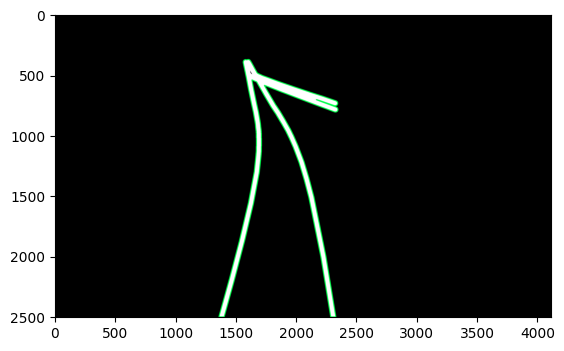

In [29]:
mask_temp = mask.copy()
imgray = cv2.cvtColor(mask_temp, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 0.5, 1, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(
    thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
cv2.drawContours(mask_temp, contours, -1, (0, 255, 75), 8)
_ = plt.imshow(mask_temp)

In [31]:
for c in contours:
    print(len(c))

5096


### Simplify contour

In [45]:
contours_small = []
for idx, contour in enumerate(contours):
    contour = np.append(contour, [contour[0]], axis=0)
    con_short = cv2.approxPolyDP(contour, epsilon=0.8, closed=True)
    points = [p for point in con_short for p in point[0]]
    points += [points[0], points[1]]
    contours_small.append(points)

In [46]:
for c in contours_small:
    print(len(c))

1296


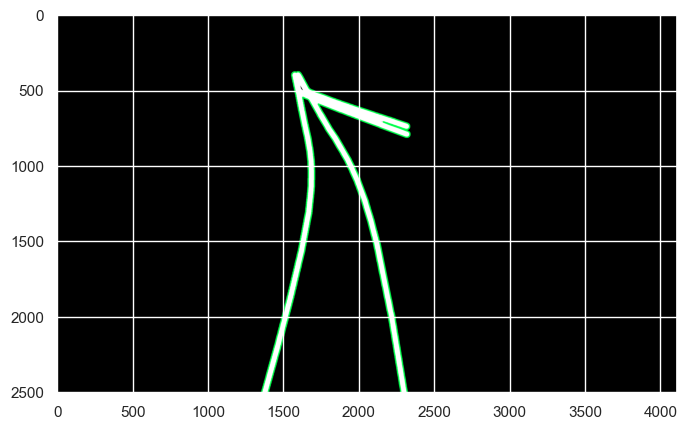

In [47]:
mask_temp = mask.copy()
cv2.drawContours(mask_temp, [con_short], -1, (0, 255, 75), 8)
_ = plt.imshow(mask_temp)

## Foramlize ideas

In [48]:
df_test["path"].iloc[0]

'10_station_suelldorf_10.1/rgb_highres_center/216_1631703820.700000022.png'

In [49]:
mask = generate_mask(df, df_test["path"].iloc[0])

In [50]:
lables, coordinates = find_contours(mask)

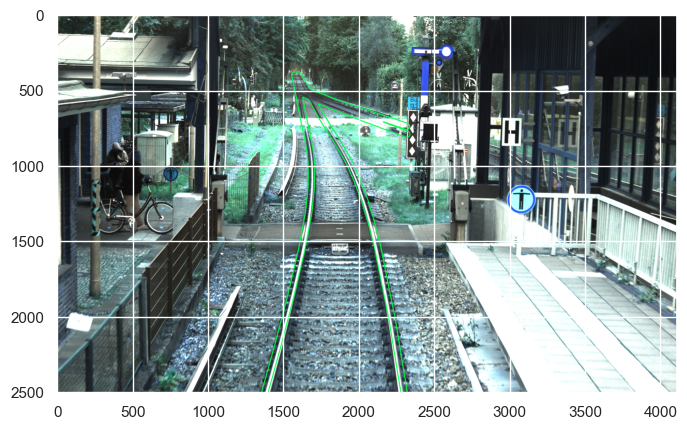

In [52]:
img_temp = img.copy()
for c in coordinates:
    cv2.drawContours(img_temp, [np.array(c)], -1, (0, 255, 75), 5)
_ = plt.imshow(img_temp)

## Generate folder structure

In [66]:
df_split.to_csv(
    f"./dataframe_dumps/df_split_{datetime.now().strftime('%m-%d-%Y_%H-%M-%S')}.csv"
)

In [35]:
datasets = {}
datasets["data_all"] = df_split
datasets["data_ir"] = df_split[df_split["sensor"].str.contains("ir_")]
datasets["data_highres"] = df_split[df_split["sensor"].str.contains("rgb_highres")]
datasets["data_rgb"] = df_split[
    df_split["sensor"].str.contains("rgb_[clr]", regex=True)
]

C:\Users\atkovacs\AppData\Local\Temp\ipykernel_14460\744763592.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


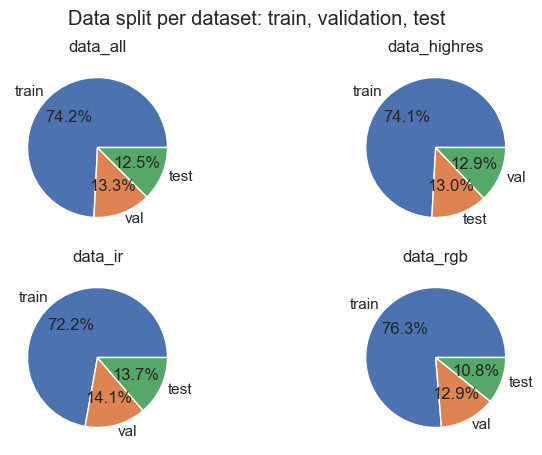

In [42]:
sns.set(rc={"figure.figsize": (8, 5)})

number_plots = len(datasets)
fig, ax = plt.subplots(2, 2)
fig.suptitle("Data split per dataset: train, validation, test")

for idx, (k, v) in enumerate(datasets.items()):
    labels = v[["path", "set"]].drop_duplicates()["set"].value_counts().index
    values = v[["path", "set"]].drop_duplicates()["set"].value_counts().values
    ax[idx % 2, idx // 2].pie(values, labels=labels, autopct="%.1f%%")
    ax[idx % 2, idx // 2].set_title(k)


fig.show()

In [69]:
path_data = "../rail_detection/datasets/"
path_yml = "../rail_detection/"
for k, v in datasets.items():
    write_dataset_to_directory(v, path_yml=path_yml, path_data=path_data, dataset=k)

## Test labeling

In [62]:
image = glob(f"{path_data}data_all/train/images/*")[0]
label = image.replace("png", "txt").replace("image", "label")

In [63]:
with open(label, "r") as f:
    labels = f.read().splitlines()

In [64]:
img = cv2.imread(image)
h, w = img.shape[:2]
h

480

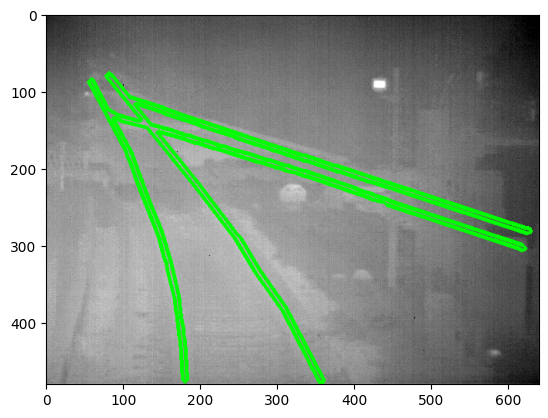

In [65]:
for label in labels:
    class_id, *poly = label.split(" ")

    poly = np.asarray(poly, dtype=np.float16).reshape(-1, 2)  # Read poly, reshape
    poly *= [w, h]  # Unscale

    cv2.polylines(img, [poly.astype("int")], True, (0, 255, 0), 4)  # Draw Poly Lines
    # cv2.fillPoly(img, [poly.astype('int')], (randint(0,255),randint(0,255),randint(0,255)), cv2.LINE_AA) # Draw area

    plt.imshow(img)